# Skin Cancer Identification

## by Nicholas Kondis

## Introduction

(add intro here)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
# read the csv file that contains the imape labels (classes)

sc_labels = pd.read_csv('GroundTruth.csv')
sc_labels.head()


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Check for missing values
sc_labels.isna().sum()

image    0
MEL      0
NV       0
BCC      0
AKIEC    0
BKL      0
DF       0
VASC     0
dtype: int64

In [4]:
for column in sc_labels.columns[1:]:
    unique_values = sc_labels[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'MEL': [0. 1.]
Unique values in column 'NV': [1. 0.]
Unique values in column 'BCC': [0. 1.]
Unique values in column 'AKIEC': [0. 1.]
Unique values in column 'BKL': [0. 1.]
Unique values in column 'DF': [0. 1.]
Unique values in column 'VASC': [0. 1.]


In [5]:
# Check for rows with multiple 1.0 labels in the binary columns
rows_with_multiple_ones = []
for index, row in sc_labels.iterrows():
    if sum(row.iloc[1:]) > 1:  # Exclude the first column
        rows_with_multiple_ones.append(index)

if rows_with_multiple_ones:
    print("Rows with multiple '1.0' labels:")
    for index in rows_with_multiple_ones:
        print(sc_labels.iloc[index])
else:
    print("No rows with multiple '1.0' labels.")


No rows with multiple '1.0' labels.


The information above indicates that we have a clean dataset, no missing values and unique identifiers for each image.

One issue that will be dealt with later is that the images are not standardized, that is the images vary in sizes.  This will be handled when the images are prepared as part of the loading step of the data to the convolution neural network.

It should be noted that the models used below will necessarily utilize different dimensional inputs (jpgs)


In [6]:


# Define the path to the dataset
data_dir = 'HAM10000'

# List all files in the directory
file_names = os.listdir(data_dir)

# Load the metadata if available (HAM10000_metadata.csv or similar)
metadata_path = os.path.join(data_dir, 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
metadata.head()


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Display the columns of the metadata
print(metadata.columns)

# Display the first few rows of the metadata
print(metadata.head())


Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [8]:
# Assuming these are the binary columns representing different types of skin cancer
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Display the first few rows to verify the new 'labels' column
print(metadata.head())



          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC labels
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL


labels
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


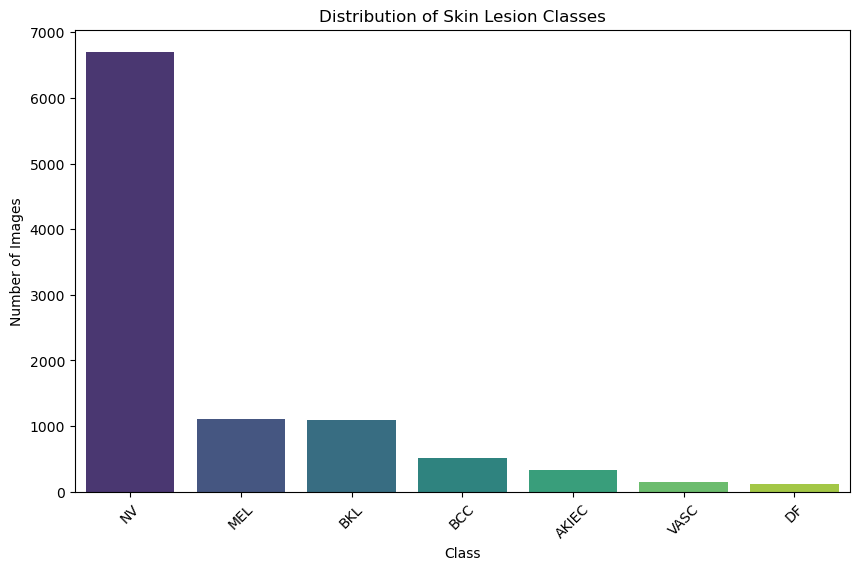

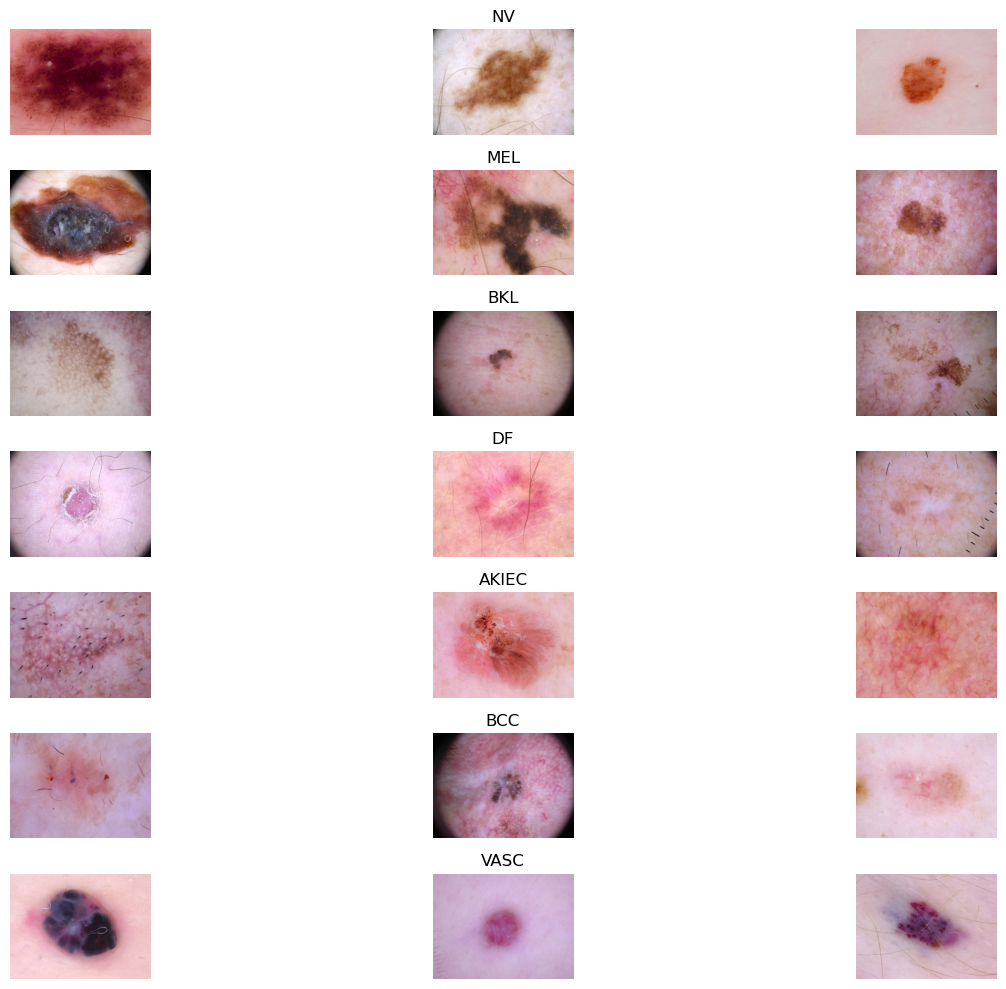

In [9]:

image_id_column = 'image'  

# Check the distribution of the classes
class_distribution = metadata['labels'].value_counts()
print(class_distribution)

# Plot the distribution of the classes
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, hue=class_distribution.index, palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Define a function to display example images from each class
def display_examples(metadata, data_dir, image_id_column, num_examples=3):
    classes = metadata['labels'].unique()
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        class_images = metadata[metadata['labels'] == cls].sample(num_examples, random_state=42)[image_id_column].values
        for j, img_id in enumerate(class_images):
            img_path = os.path.join(data_dir, img_id + '.jpg')
            img = Image.open(img_path)
            plt.subplot(len(classes), num_examples, i*num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:
                plt.title(cls)
    
    plt.tight_layout()
    plt.show()

# Display example images
display_examples(metadata, 'HAM10000/images', image_id_column)


The bar chart contains a clear data imbalance (67% NV).

In this part, we'll address the class imbalance issue by using data augmentation and oversampling the minority classes.

This is coded below:

In [10]:
import os
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load metadata
metadata_path = os.path.join('HAM10000', 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
print(metadata.head())

# Class columns representing different types of skin cancer
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Ensure the image filenames are correctly formatted
metadata['image'] = metadata['image'].apply(lambda x: x + '.jpg')

# Display the first few rows to verify the new 'labels' and 'image' columns
print(metadata.head())

# Extract features and labels
X = metadata['image']
y = metadata['labels']

# Resample the dataset
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the resampled data
resampled_metadata = pd.DataFrame({
    'image': X_resampled.flatten(),
    'labels': y_resampled
})

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Save resampled metadata for later use
resampled_metadata.to_csv('resampled_metadata.csv', index=False)


          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC labels
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL
Found 46935 validated image filenames belonging to 7 classes.


### Building the initial neural net model: model_my_nn

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal

# Build the model
model_my_nn = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(len(class_columns), activation='softmax')
])

# Compile the model, optimizer, loss, and metrics uses the most common for classification
model_my_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_my_nn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,439 (12.61 MB)

 Trainable params: 3,305,991 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/25


C:\Users\nickk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 188s 716ms/step - accuracy: 0.5574 - loss: 3.1696 - val_accuracy: 0.5657 - val_loss: 1.3484
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 180s 705ms/step - accuracy: 0.6505 - loss: 1.1812 - val_accuracy: 0.6825 - val_loss: 2.6301
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 180s 704ms/step - accuracy: 0.6546 - loss: 1.1264 - val_accuracy: 0.6855 - val_loss: 1.0370
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 181s 707ms/step - accuracy: 0.6608 - loss: 1.0836 - val_accuracy: 0.6695 - val_loss: 1.1776
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 179s 702ms/step - accuracy: 0.6651 - loss: 1.0379 - val_accuracy: 0.6730 - val_loss: 0.9827
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 178s 696ms/step - accuracy: 0.6628 - loss: 0.9891 - val_accuracy: 0.6860 - val_loss: 1.4369
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 178s 697ms/step - accuracy: 0.6706 - loss: 0.9633 - val_accuracy: 0.6860 - val_loss: 0.9139
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 178s 698ms/step - accuracy: 0.6670 - loss: 0.95

C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


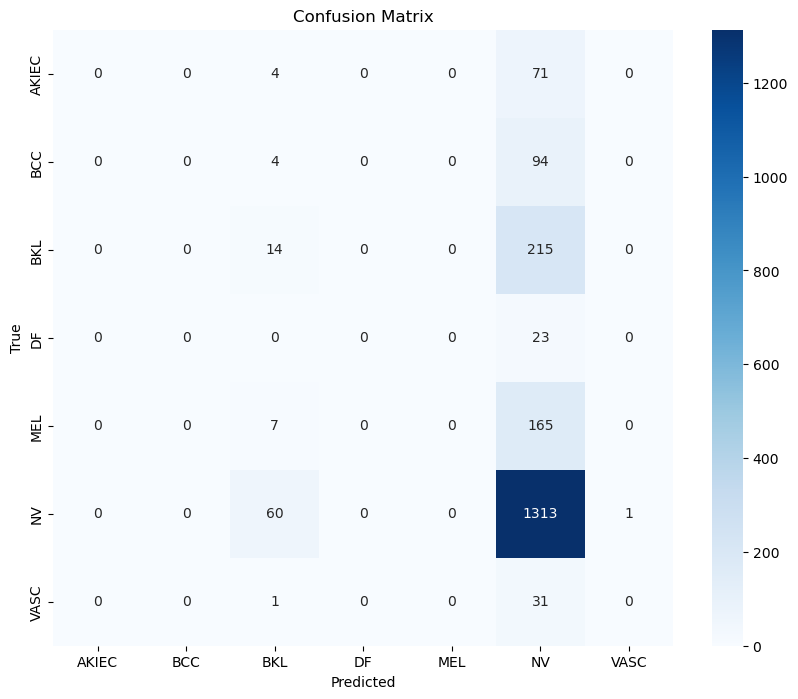

In [14]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load metadata
metadata_path = os.path.join('HAM10000', 'GroundTruth.csv')
metadata = pd.read_csv(metadata_path)

# Class columns representing different types of skin cancer
class_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Create a function to map binary columns to a single label
def map_labels(row):
    for col in class_columns:
        if row[col] == 1.0:
            return col
    return 'unknown'

# Apply the function to create the 'labels' column
metadata['labels'] = metadata.apply(map_labels, axis=1)

# Ensure the image filenames are correctly formatted
metadata['image'] = metadata['image'].apply(lambda x: x + '.jpg')

# Define image size and batch size
image_size = (128, 128)  # Adjust based on the model requirements
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build and compile the model
model_my_nn = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_columns), activation='softmax')
])

model_my_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_my_nn.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model on the validation set
loss, accuracy = model_my_nn.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.4f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_my_nn.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model after training
model_my_nn.save('model_my_nn.keras')



This model is over classifying NV.

To improve accuracy, I will try a more complex (Increased layered) neural network labeled model_my_nn_2


## Trying another model:
Key Differences between model_my_nn and model_my_nn_2
Kernel Initializer:

model_my_nn uses HeNormal initializer for all convolutional and dense layers.
model uses the default initializer (typically GlorotUniform) for convolutional and dense layers.
Number of Layers:

model_my_nn has three convolutional layers followed by max-pooling layers.
model has four convolutional layers followed by max-pooling layers.

Number of Filters:

model_my_nn has convolutional layers with 32, 64, and 128 filters.
model has convolutional layers with 32, 64, 128, and 256 filters.

Dense Layers:

model_my_nn has a dense layer with 128 units.
model_my_nn_2 has a dense layer with 512 units.

In [16]:
# Build another more complex model, model_my_nn_2
model_my_nn_2 = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_columns), activation='softmax')
])

# Compile the model with a lower learning rate
model_my_nn_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Display the model summary
model_my_nn_2.summary()

# Train the model
history = model_my_nn_2.fit(
    train_generator,
    epochs=50,  # Increase the number of epochs
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_my_nn_2.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')


# Save the model after training
model_my_nn_2.save('model_my_nn_2.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,113,031 (19.50 MB)

 Trainable params: 5,112,071 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 610ms/step - accuracy: 0.6131 - loss: 1.4988 - val_accuracy: 0.1053 - val_loss: 3.0272
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 605ms/step - accuracy: 0.6867 - loss: 0.8818 - val_accuracy: 0.7149 - val_loss: 1.1052
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 605ms/step - accuracy: 0.6989 - loss: 0.8472 - val_accuracy: 0.7414 - val_loss: 0.7228
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 604ms/step - accuracy: 0.6998 - loss: 0.8117 - val_accuracy: 0.7529 - val_loss: 0.6915
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 610ms/step - accuracy: 0.6948 - loss: 0.8127 - val_accuracy: 0.7529 - val_loss: 0.6476
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 607ms/step - accuracy: 0.7148 - loss: 0.7556 - val_accuracy: 0.7698 - val_loss: 0.6401
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 606ms/step - accuracy: 0.7264 - loss: 0.7295 - val_accuracy: 0.7484 - val_loss: 0.6793
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 607ms/step - accuracy: 0.7236 -

63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step
Classification Report
              precision    recall  f1-score   support

       AKIEC       0.05      0.12      0.07        75
         BCC       0.09      0.18      0.12        98
         BKL       0.13      0.06      0.08       229
          DF       0.00      0.00      0.00        23
         MEL       0.13      0.09      0.11       172
          NV       0.71      0.71      0.71      1374
        VASC       0.00      0.00      0.00        32

    accuracy                           0.52      2003
   macro avg       0.16      0.17      0.16      2003
weighted avg       0.52      0.52      0.51      2003



C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


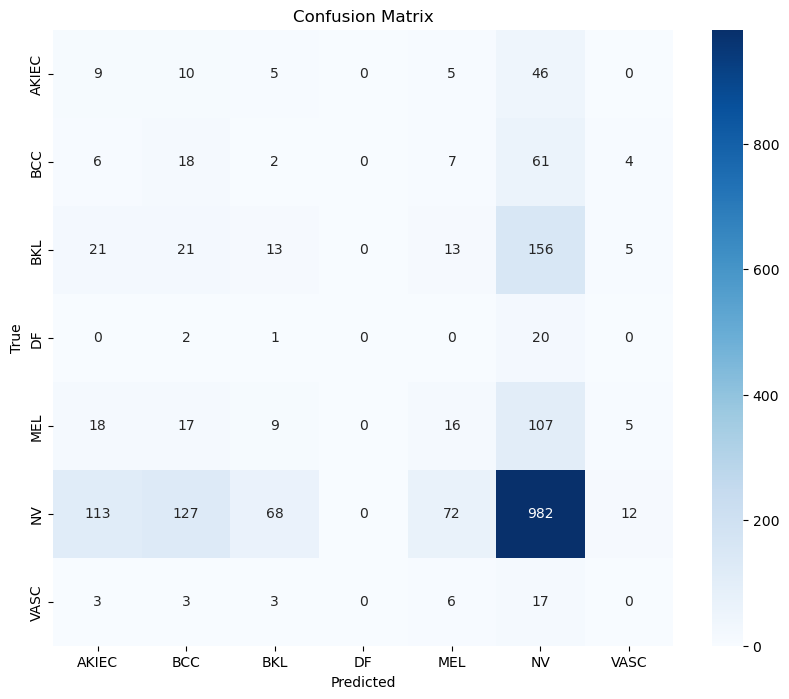

In [17]:
# Get predictions on the validation set
validation_generator.reset()
predictions = model_my_nn_2.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Results of new neural network model (model_my_nn_2)

The new model has shown improvement in most metrics for non-NV classification and is a clear improvement from the initial network.

To find the best possible classification, I will follow by adapting several well known, pre-trained models:

1. ResNet50
2. EfficientNetB0
3. InceptionV3
4. VGG16
5. DenseNet
6. NASNetMobile
7. Xception


### Try Resnet

Found 37548 validated image filenames belonging to 7 classes.
Found 9387 validated image filenames belonging to 7 classes.
Epoch 1/50


C:\Users\nickk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1222s 1s/step - accuracy: 0.1667 - loss: 1.9004 - val_accuracy: 0.0167 - val_loss: 4.4508
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1153s 980ms/step - accuracy: 0.1818 - loss: 1.8332 - val_accuracy: 0.0145 - val_loss: 3.2776
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1067s 908ms/step - accuracy: 0.1789 - loss: 1.8333 - val_accuracy: 0.0150 - val_loss: 3.5870
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1032s 877ms/step - accuracy: 0.1850 - loss: 1.8283 - val_accuracy: 0.0138 - val_loss: 3.1282
Epoch 5/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1038s 883ms/step - accuracy: 0.1901 - loss: 1.8225 - val_accuracy: 0.0160 - val_loss: 3.4245
Epoch 6/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1043s 887ms/step - accuracy: 0.2007 - loss: 1.8118 - val_accuracy: 0.0527 - val_loss: 3.5905
Epoch 7/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1038s 883ms/step - accuracy: 0.2119 - loss: 1.8074 - val_accuracy: 0.0187 - val_loss: 3.5218
Epoch 8/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1035s 880ms/step - accuracy

C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nickk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


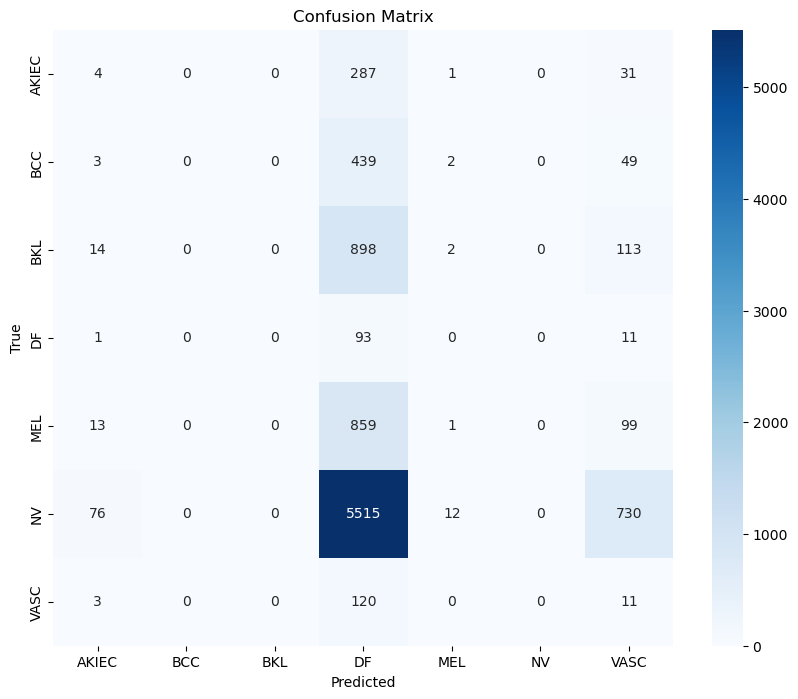

In [26]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the dataset
data_dir = 'HAM10000/images'

# Load resampled metadata
resampled_metadata_path = 'resampled_metadata.csv'
resampled_metadata = pd.read_csv(resampled_metadata_path)

# Define image size and batch size
image_size = (224, 224)  # Ensure the images are resized to 224x224
batch_size = 32

# Initialize ImageDataGenerator without data augmentation for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=resampled_metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(resampled_metadata['labels'].unique()), activation='softmax')(x)

# Build the complete model
model_Resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model_Resnet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Load the best model
model_Resnet.load_weights('best_model.keras')

# Evaluate the model
loss, accuracy = model_Resnet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the model after training
model_Resnet.save('model_Resnet.keras')


In [22]:
# Get predictions on the validation set
validation_generator.reset()
predictions = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.6604 - loss: 1.1211 - val_accuracy: 0.6885 - val_loss: 1.1549
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.6824 - loss: 0.9983 - val_accuracy: 0.6880 - val_loss: 1.1522
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.6760 - loss: 0.9877 - val_accuracy: 0.6895 - val_loss: 1.1671
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.6717 - loss: 0.9734 - val_accuracy: 0.6345 - val_loss: 1.1030
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.6851 - loss: 0.9437 - val_accuracy: 0.6905 - val_loss: 0.9795
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.6753 - loss: 0.9643 - val_accuracy: 0.6925 - val_loss: 1.0163
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - accuracy: 0.6664 - loss: 0.9554 - val_accuracy: 0.6875 - val_loss: 0.9272
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.6831 - loss: 0.9415 - val_accu

### Try EfficientNetB0 

In [23]:
from tensorflow.keras.applications import EfficientNetB0


# Define image size and batch size for EfficientNetB0, 224x224
image_size = (224, 224)  
batch_size = 32

# Initialize ImageDataGenerator with data augmentation for adjusted image size
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator_Eff = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator_Eff = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_Eff = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Eff.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Display the model summary
model_Eff.summary()

# Train the model
history = model_Eff.fit(
    train_generator_Eff,
    epochs=50,
    validation_data=validation_generator_Eff
)

# Evaluate the model
loss, accuracy = model_Eff.evaluate(validation_generator_Eff)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Save the model_Eff
model_Eff.save('model_Eff.keras')

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC labels
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 5,368,490 (20.48 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50


C:\Users\nickk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.6365 - loss: 1.3237 - val_accuracy: 0.6860 - val_loss: 1.1125
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6703 - loss: 1.1338 - val_accuracy: 0.6860 - val_loss: 1.1134
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.6602 - loss: 1.1544 - val_accuracy: 0.6860 - val_loss: 1.1121
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6585 - loss: 1.1620 - val_accuracy: 0.6860 - val_loss: 1.1128
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.6595 - loss: 1.1589 - val_accuracy: 0.6860 - val_loss: 1.1126
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.6655 - loss: 1.1498 - val_accuracy: 0.6860 - val_loss: 1.1129
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6606 - loss: 1.1525 - val_accuracy: 0.6860 - val_loss: 1.1092
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.6613 - loss: 1.1532 - val_accuracy: 0.686

### Try InceptionV3 Pre-trained Model

In [26]:

from tensorflow.keras.applications import InceptionV3

# Define image size and batch size, InceptionV3 employs 299x299 images
image_size = (299, 299)
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_IncV3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_IncV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_IncV3.summary()

# Train the model
history = model_IncV3.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_IncV3.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_IncV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_IncV3.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_IncV3.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_IncV3.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Save the model_VGG16
model_IncV3.save('model_IncV3.keras')

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC labels
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0     NV
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0    MEL
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 149, 149, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 149, 149, 32)      │              96 │ conv2d_7[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 147, 147, 32)      │              96 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 147, 147, 64)      │             192 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_6[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 73, 73, 80)        │             240 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_7[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 71, 71, 192)       │         138,24

 Total params: 23,908,135 (91.20 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/50


C:\Users\nickk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.6363 - loss: 1.1290 - val_accuracy: 0.7209 - val_loss: 0.8054
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.6881 - loss: 0.8700 - val_accuracy: 0.7224 - val_loss: 0.7987
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.7170 - loss: 0.7919 - val_accuracy: 0.7424 - val_loss: 0.7402
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.7207 - loss: 0.7725 - val_accuracy: 0.7394 - val_loss: 0.7185
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.7245 - loss: 0.7607 - val_accuracy: 0.7429 - val_loss: 0.7223
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - accuracy: 0.7314 - loss: 0.7413 - val_accuracy: 0.7459 - val_loss: 0.6955
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.7336 - loss: 0.7244 - val_accuracy: 0.7414 - val_loss: 0.7061
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.7351 - loss: 0.7159 - val_accuracy: 0.765

### Try VGG16

In [ ]:

from tensorflow.keras.applications import VGG16


# Define image size and batch size, VGG16 uses 224x224 images
image_size = (224, 224)
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_VGG16.summary()

# Train the model
history = model_VGG16.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_VGG16.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_VGG16.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_VGG16.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_VGG16.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_VGG16.save('model_VGG16.keras')

### Try DenseNet

In [ ]:

from tensorflow.keras.applications import DenseNet121


# Define image size and batch size, DenseNet121 expects 224x224 images
image_size = (224, 224)  
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_DenseNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Display the model summary
model_DenseNet.summary()

# Train the model
history = model_DenseNet.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_DenseNet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_DenseNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_DenseNet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_DenseNet.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_DenseNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_DenseNet.save('model_DenseNet.keras')

### Try NASNet 

In [ ]:

from tensorflow.keras.applications import NASNetMobile


# Define image size and batch size
image_size = (224, 224)  # NASNetMobile expects 224x224 images
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the NASNetMobile model pre-trained on ImageNet
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_NASNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_NASNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Display the model summary
model_NASNet.summary()

# Train the model
history = model_NASNet.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_NASNet.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_NASNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_NASNet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_NASNet.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_NASNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_NASNet.save('model_NASNet.keras')

### Try Xception 

In [ ]:

from tensorflow.keras.applications import Xception


# Define image size and batch size, Xception uses 299x299 images
image_size = (299, 299) 
batch_size = 32

# Initialize ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data for validation
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',  # Ensure this is the correct column name
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load the Xception model pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_columns), activation='softmax')(x)

# Build the complete model
model_Xcept = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_Xcept.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Display the model summary
model_Xcept.summary()

# Train the model
history = model_Xcept.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model_Xcept.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

# Unfreeze some layers of the base model
base_model.trainable = True

# Recompile the model with a lower learning rate
model_Xcept.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# Train the model again with fine-tuning
history_fine = model_Xcept.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model after fine-tuning
loss, accuracy = model_Xcept.evaluate(validation_generator)
print(f'Validation accuracy after fine-tuning: {accuracy * 100:.2f}%')

# Get predictions on the validation set
validation_generator.reset()
predictions = model_Xcept.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predicted_class_indices = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


model_Xcept.save('model_Xcept.keras')

## Make a dataframe of the classification accuracy for each model

Here I am creating a dataframe to visualize the individual accuracies of each modl


In [ ]:
# Define image size and batch size
image_size = (299, 299)  # Adjust based on the model requirements
batch_size = 32

# Initialize ImageDataGenerator without data augmentation for validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=metadata,
    directory=data_dir,
    x_col='image',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Dictionary to store accuracies
accuracies = {model_name: {label: 0 for label in class_columns} for model_name in model_filenames}

# Function to calculate category-wise accuracy
def calculate_category_wise_accuracy(true_labels, predicted_labels, labels):
    accuracy_dict = {}
    for label in labels:
        true_class_indices = np.where(true_labels == labels.index(label))[0]
        predicted_class_indices = np.where(predicted_labels == labels.index(label))[0]
        correct_predictions = len(set(true_class_indices) & set(predicted_class_indices))
        accuracy_dict[label] = correct_predictions / len(true_class_indices) if len(true_class_indices) > 0 else 0
    return accuracy_dict

# Load and evaluate each model
for model_filename in model_filenames:
    model = load_model(model_filename)
    predictions = model.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
    predicted_class_indices = np.argmax(predictions, axis=1)
    true_labels = validation_generator.classes
    labels = list(validation_generator.class_indices.keys())
    
    accuracy_dict = calculate_category_wise_accuracy(true_labels, predicted_class_indices, labels)
    for label, accuracy in accuracy_dict.items():
        accuracies[model_filename][label] = accuracy

# Create a DataFrame from the accuracies dictionary
accuracies_df = pd.DataFrame(accuracies).T
accuracies_df.columns = class_columns

# Display the DataFrame
print(accuracies_df)


### Creating an ensemble of neural networks

This approach involves:

1. Creating multiple variations of created neural network architecture. 
2. Training each variation independently.
3. Using the average of the predictions from all trained models for the final classification. 

This ensemble method will try to improve the accuracy and robustness of your classification model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(variation):
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))
    
    if variation == 1:
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
    elif variation == 2:
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    elif variation == 3:
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
    
    model.add(Dense(len(class_columns), activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Train each model
models = []
variations = [1, 2, 3]
for variation in variations:
    print(f"Training model variation {variation}")
    model = create_model(variation)
    model.fit(train_generator, epochs=25, validation_data=validation_generator)
    models.append(model)
    model.save(f'model_variation_{variation}.keras')


### Average the Predictions

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load models
models = [load_model(f'model_variation_{i}.keras') for i in variations]

# Get predictions from each model
predictions = [model.predict(validation_generator) for model in models]

# Average the predictions
avg_predictions = np.mean(predictions, axis=0)

# Get the final predicted class indices
predicted_class_indices = np.argmax(avg_predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Load the Trained Models and Generate Predictions By Average

Next, I will try an ensemble of all created networks to try and provide the most accurate predictive mode


In [ ]:

# Load the saved models
model_my_nn = load_model('model_my_nn.keras')
model_my_nn_2 = load_model('model_my_nn_2.keras')
model_Resnet = load_model('model_Resnet.keras')
model_Eff = load_model('model_Eff.keras')
model_IncV3 = load_model('model_IncV3.keras')
model_VGG16 = load_model('model_VGG16.hkeras')
model_DenseNet = load_model('model_DenseNet.keras')
model_NASNet = load_model('model_NASNet.keras')
model_Xcept = load_model('model_Xcept.keras')

# Generate predictions
predictions_my_nn = model_my_nn.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_my_nn_2 = model_my_nn_2.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Resnet = model_Resnet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Eff = model_Eff.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_IncV3 = model_IncV3.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_VGG16 = model_VGG16.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_DenseNet = model_DenseNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_NASNet = model_NASNet.predict(validation_generator, steps=validation_generator.n // batch_size + 1)
predictions_Xcept = model_Xcept.predict(validation_generator, steps=validation_generator.n // batch_size + 1)

# Average the predictions
average_predictions = (predictions_my_nn + predictions_my_nn_2 + predictions_Resnet + predictions_Eff +
                       predictions_IncV3 + predictions_VGG16 + predictions_DenseNet + predictions_NASNet +
                       predictions_Xcept) / 9

# Assign the category based on the highest average probability
predicted_class_indices = np.argmax(average_predictions, axis=1)

# Get the true labels
true_labels = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Print a classification report
print('Classification Report')
print(classification_report(true_labels, predicted_class_indices, target_names=labels))

# Plot a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
